In [ ]:
!pip install --user phate scprep umap-learn phenograph

In [1]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

import sys
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#font = {'size'   : 14}
#mpl.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
from scipy import stats

import sklearn
import sklearn.cluster
import sklearn.datasets

import phate
import umap
import scprep

import graphtools as gt

import phenograph

<a id='loading'></a>
# 1. Loading preprocessed data

### Load EB Data (and download if needed)

In [2]:
home = os.path.expanduser('~')
file_path = os.path.join(home, 'scRNAseq', 'EBT_counts.pkl.gz')
if not os.path.exists(file_path):
    scprep.io.download.download_google_drive(id='1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM',
                        destination=os.path.dirname(file_path))
data = pd.read_pickle(file_path)

In [3]:
metadata = pd.DataFrame([ix.split('_')[1] for ix in data.index], columns=['sample'], index=data.index)

# 2. Imputation using MAGIC

As we mentioned, because scRNA-seq, suffers from dropout (the undercounting of mRNA molecules in single cells), examining expression lowly expressed genes can be challenging. To overcome this, we developed a method for imputation called MAGIC (Markov Affinity Graph Imputation in Cells; [PMID: 29961576 ](https://www.ncbi.nlm.nih.gov/pubmed/29961576)). 

Without going into too much detail about how it works, the basic idea is that although gene expression counts in each cell are unreliable, the gene expression counts matrix contains several degrees of redundancy between genes (i.e. expression of genes is not completely indepdent) and among cells (i.e. we see very similar cells more than once).

A full description of MAGIC can be found in the paper, and on our website: [Denoising and imputing scRNA-seq data](https://www.krishnaswamylab.org/blog/2018/10/28/denoising-noisy-gene-expression-in-scrna-seq).

#### Running MAGIC

Because MAGIC returns a dense matrix (many zeros in the counts matrix are removed), we only want to keep expression of a few marker genes. The list in the following cell was gathering while analyzing the data, and we'll look at them later.



In [4]:
full_marker_genes = ['ARID3A (ENSG00000116017)', 'ASCL2 (ENSG00000183734)',  'CD34 (ENSG00000174059)',
 'CDX2 (ENSG00000165556)', 'CER1 (ENSG00000147869)', 'DLX1 (ENSG00000144355)',
 'DMRT3 (ENSG00000064218)', 'EN2 (ENSG00000164778)', 'EOMES (ENSG00000163508)',
 'FOXA2 (ENSG00000125798)', 'FOXD3-AS1 (ENSG00000230798)', 'GATA3-AS1 (ENSG00000197308)',
 'GATA4 (ENSG00000136574)', 'GATA5 (ENSG00000130700)', 'GATA6-AS1 (ENSG00000266010)',
 'GBX2 (ENSG00000168505)', 'GLI3 (ENSG00000106571)', 'HOXA2 (ENSG00000105996)',
 'HOXB1 (ENSG00000120094)', 'HOXB4 (ENSG00000182742)', 'HOXD13 (ENSG00000128714)',
 'HOXD9 (ENSG00000128709)', 'ISL1 (ENSG00000016082)', 'KLF5 (ENSG00000102554)',
 'KLF7 (ENSG00000118263)', 'LEF1 (ENSG00000138795)', 'LHX2 (ENSG00000106689)',
 'LHX5 (ENSG00000089116)', 'LMX1A (ENSG00000162761)', 'MAP2 (ENSG00000078018)',
 'MIXL1 (ENSG00000185155)', 'MYCBP (ENSG00000214114)', 'NANOG (ENSG00000111704)',
 'NES (ENSG00000132688)', 'NKX2-1 (ENSG00000136352)', 'NKX2-5 (ENSG00000183072)',
 'NKX2-8 (ENSG00000136327)', 'NPAS1 (ENSG00000130751)', 'NR2F1-AS1 (ENSG00000237187)',
 'OLIG1 (ENSG00000184221)', 'OLIG3 (ENSG00000177468)', 'ONECUT1 (ENSG00000169856)',
 'ONECUT2 (ENSG00000119547)', 'OTX2 (ENSG00000165588)', 'PAX3 (ENSG00000135903)',
 'PAX6 (ENSG00000007372)', 'PDGFRA (ENSG00000134853)', 'PECAM1 (ENSG00000261371)',
 'POU5F1 (ENSG00000204531)', 'SATB1 (ENSG00000182568)', 'SIX2 (ENSG00000170577)',
 'SIX3-AS1 (ENSG00000236502)', 'SIX6 (ENSG00000184302)', 'SOX13 (ENSG00000143842)',
 'SOX10 (ENSG00000100146)', 'SOX15 (ENSG00000129194)', 'SOX17 (ENSG00000164736)',
 'SOX9 (ENSG00000125398)', 'TTLL10 (ENSG00000162571)', 'TAL1 (ENSG00000162367)',
 'TBX15 (ENSG00000092607)', 'TBX18 (ENSG00000112837)', 'TBX5 (ENSG00000089225)',
 'TNNT2 (ENSG00000118194)', 'WT1 (ENSG00000184937)', 'ZBTB16 (ENSG00000109906)',
 'ZIC2 (ENSG00000043355)', 'ZIC5 (ENSG00000139800)', 'ACTB (ENSG00000075624)',
 'HAND1 (ENSG00000113196)']

In [5]:
data_magic = magic.MAGIC().fit_transform(data, genes=full_marker_genes)

Calculating MAGIC...
  Running MAGIC on 16821 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.74 seconds.
    Calculating KNN search...
    Calculated KNN search in 33.76 seconds.
    Calculating affinities...
    Calculated affinities in 14.76 seconds.
  Calculated graph and diffusion operator in 58.61 seconds.
  Calculating imputation...
    Automatically selected t = 10
  Calculated imputation in 3.33 seconds.
Calculated MAGIC in 68.28 seconds.


In [6]:
data_magic.head()

,TTLL10 (ENSG00000162571),MYCBP (ENSG00000214114),TAL1 (ENSG00000162367),FOXD3-AS1 (ENSG00000230798),TBX15 (ENSG00000092607),NES (ENSG00000132688),LMX1A (ENSG00000162761),TNNT2 (ENSG00000118194),SOX13 (ENSG00000143842),CD34 (ENSG00000174059),...,PECAM1 (ENSG00000261371),SOX9 (ENSG00000125398),GATA6-AS1 (ENSG00000266010),ONECUT2 (ENSG00000119547),FOXA2 (ENSG00000125798),GATA5 (ENSG00000130700),ARID3A (ENSG00000116017),NPAS1 (ENSG00000130751),SOX10 (ENSG00000100146),OLIG1 (ENSG00000184221)
AAACCGTGCAGAAA-1_Day 00-03,0.001575,0.143601,-0.000404,0.109995,-0.000703,0.180299,0.014986,0.006369,0.032414,-0.000019,...,-0.000321,0.047533,0.002640,0.004470,0.003487,0.007686,0.103217,0.036340,0.008774,0.003610
AAACGCACCGGTAT-1_Day 00-03,0.002248,0.176734,-0.000351,0.727412,0.001345,0.102273,-0.001623,0.037798,0.045791,-0.001094,...,-0.000118,0.013143,0.009204,0.008113,0.006045,-0.000910,0.117009,0.050260,-0.000341,0.001144
AAACGCACCTATTC-1_Day 00-03,0.002606,0.178205,0.000546,0.725480,0.001504,0.110371,-0.001731,0.027422,0.043979,-0.000638,...,-0.000180,0.016307,0.004782,0.007640,0.009659,-0.001017,0.110664,0.047389,0.002546,-0.001288
AAAGATCTCTGCTC-1_Day 00-03,0.001700,0.133769,-0.000278,0.083908,-0.000381,0.179891,0.019935,0.008310,0.030771,0.000247,...,-0.000496,0.043291,-0.000156,0.004305,0.002938,0.006931,0.099171,0.036735,0.008030,0.008737
AAAGATCTGGTACT-1_Day 00-03,0.002165,0.176467,-0.000457,0.725451,0.001230,0.101380,-0.001615,0.038851,0.045784,-0.001176,...,-0.000099,0.012407,0.009596,0.008168,0.005678,-0.000950,0.117297,0.050240,-0.000636,0.001164


# 3. Visualizing the data

We've already spent time discussing visualizations of this data using tSNE, PHATE, and UMAP. Here, we're going to focus on PHATE, but feel free to try running another algorithm here.

In [8]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 16821 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.25 seconds.
    Calculating KNN search...
    Calculated KNN search in 12.87 seconds.
    Calculating affinities...
    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 22.79 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.30 seconds.
    Calculating KMeans...
    Calculated KMeans in 27.83 seconds.
  Calculated landmark operator in 30.93 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.83 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.31 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 16.18 seconds.
Calculated PHATE in 71.05 seconds.


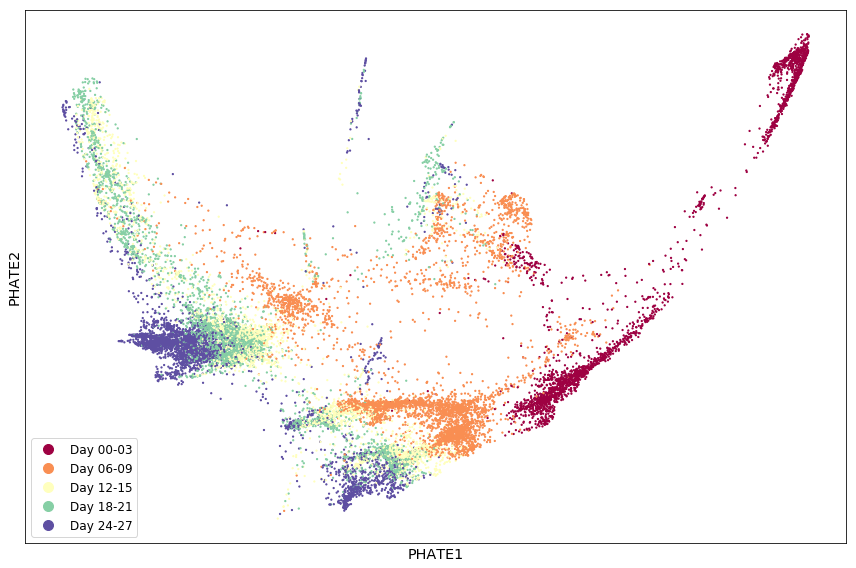

In [9]:
scprep.plot.scatter2d(data_phate, c=metadata['sample'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

# 4. Clustering

## 4.1 Introduction to clustering

#### What is clustering?

The goal of clustering is to identify a partition of the data such that all of the observations within each partition (called a cluster) are more similar to each other than they are to those in other clusters. Many clustering algorithms exist, and they each have their own quirks (just like visualization algorithms). `sklearn` has implementations for some of the most popular ones and their [User Guide on Clustering](https://scikit-learn.org/stable/modules/clustering.html) is a good resource to understand general clustering approaches.

In [11]:
data_pca = scprep.reduce.pca(data, n_components=50)

In [12]:
tic = time.time()
phenograph_clusters, _, _ = phenograph.cluster(data_pca)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 17.98881959915161 seconds
Jaccard graph constructed in 7.779731035232544 seconds
Wrote graph to binary file in 1.8066151142120361 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.859184
After 5 runs, maximum modularity is Q = 0.860597
After 13 runs, maximum modularity is Q = 0.861905
Louvain completed 33 runs in 17.925228595733643 seconds
PhenoGraph complete in 45.56911253929138 seconds


In [34]:
tic = time.time()
kmeans_clusters = sklearn.cluster.KMeans(n_clusters=20).fit_predict(data_pca)
print('Finished KMeans clustering in {:.2f} seconds'.format(time.time() - tic))

Finished KMeans clustering in 3.44 seconds


In [14]:
G = gt.Graph(scprep.reduce.pca(data, n_components=50))
G_igraph = G.to_igraph()

In [15]:
import louvain
tic = time.time()
part = louvain.find_partition(G_igraph, louvain.RBConfigurationVertexPartition, 
                              weights="weight", resolution_parameter=1)
louvain_clusters = np.array(part.membership)
print('Finished Louvain in {:.2f} seconds'.format(time.time() - tic))

Finished Louvain in 16.58 seconds


In [35]:
tic = time.time()
spec_op = sklearn.cluster.SpectralClustering(n_clusters=20, affinity='precomputed')
spectral_clusters = spec_op.fit_predict(G.K.toarray())
print('Finished Spectral clustering in {:.2f} seconds'.format(time.time() - tic))

Finished Spectral clustering in 36.19 seconds


## 4.2 Clustering single cell data

#### Clustering methods for single cell RNA-seq

In the previous exercise, we compared three popular algorithms for clustering: KMeans, Spectral Clustering, and Louvain.

#### Reordering clusters by PHATE coordinates

By default, cluster numbers are meaningless. This makes it difficult to compare clusterings, because cluster "0" can refer to entirely different cells between runs of the same algorithm.

To enforce some consistency, we are going to reorder the clusters so that cluster "0" is always on the far right of the PHATE plot, and the highest-numbered cluster is always on the far left.

In [36]:
clusterings = {'Phenograph':phenograph_clusters,
               'Louvain':louvain_clusters, 
               'KMeans':kmeans_clusters, 
               'Spectral':spectral_clusters}

for alg in clusterings:
    cl_nu = scprep.utils.sort_clusters_by_values(clusterings[alg], -data_phate.iloc[:,0])
    clusterings[alg] = cl_nu

#### Plotting clusters with PHATE

Above, we colored our scatter plots using expression of a marker gene. However, we can use any information with one value per cell to color the plot. Here, we're using the cluster identity.

In [46]:
cluster_cmap = plt.cm.tab20(np.linspace(0, 1, 20))

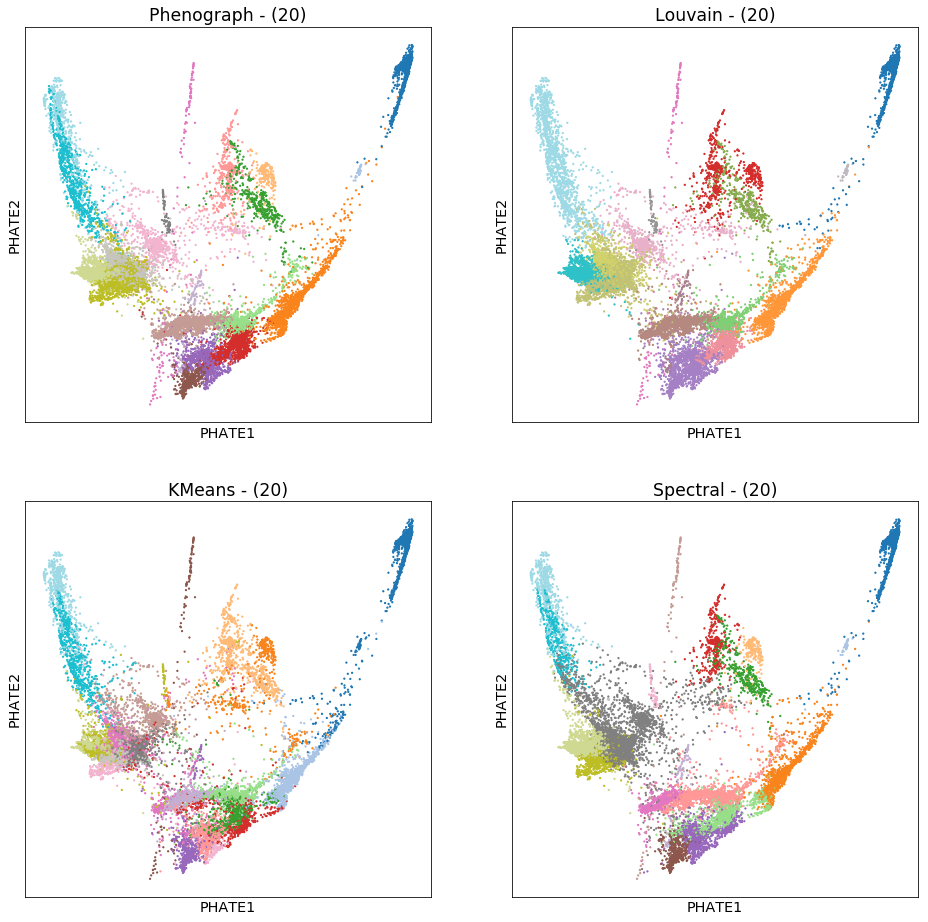

In [58]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

for i, algorithm in enumerate(clusterings):
    ax = axes.flatten()[i]
    scprep.plot.scatter2d(data_phate, c=clusterings[algorithm], cmap=cluster_cmap,
                          title='{} - ({})'.format(algorithm, len(np.unique(clusterings[alg]))), 
                      ticks=False, label_prefix="PHATE", legend=False, discrete=True,
                         ax=ax)

We can also plot each cluster individually to see where they are on the PHATE plot




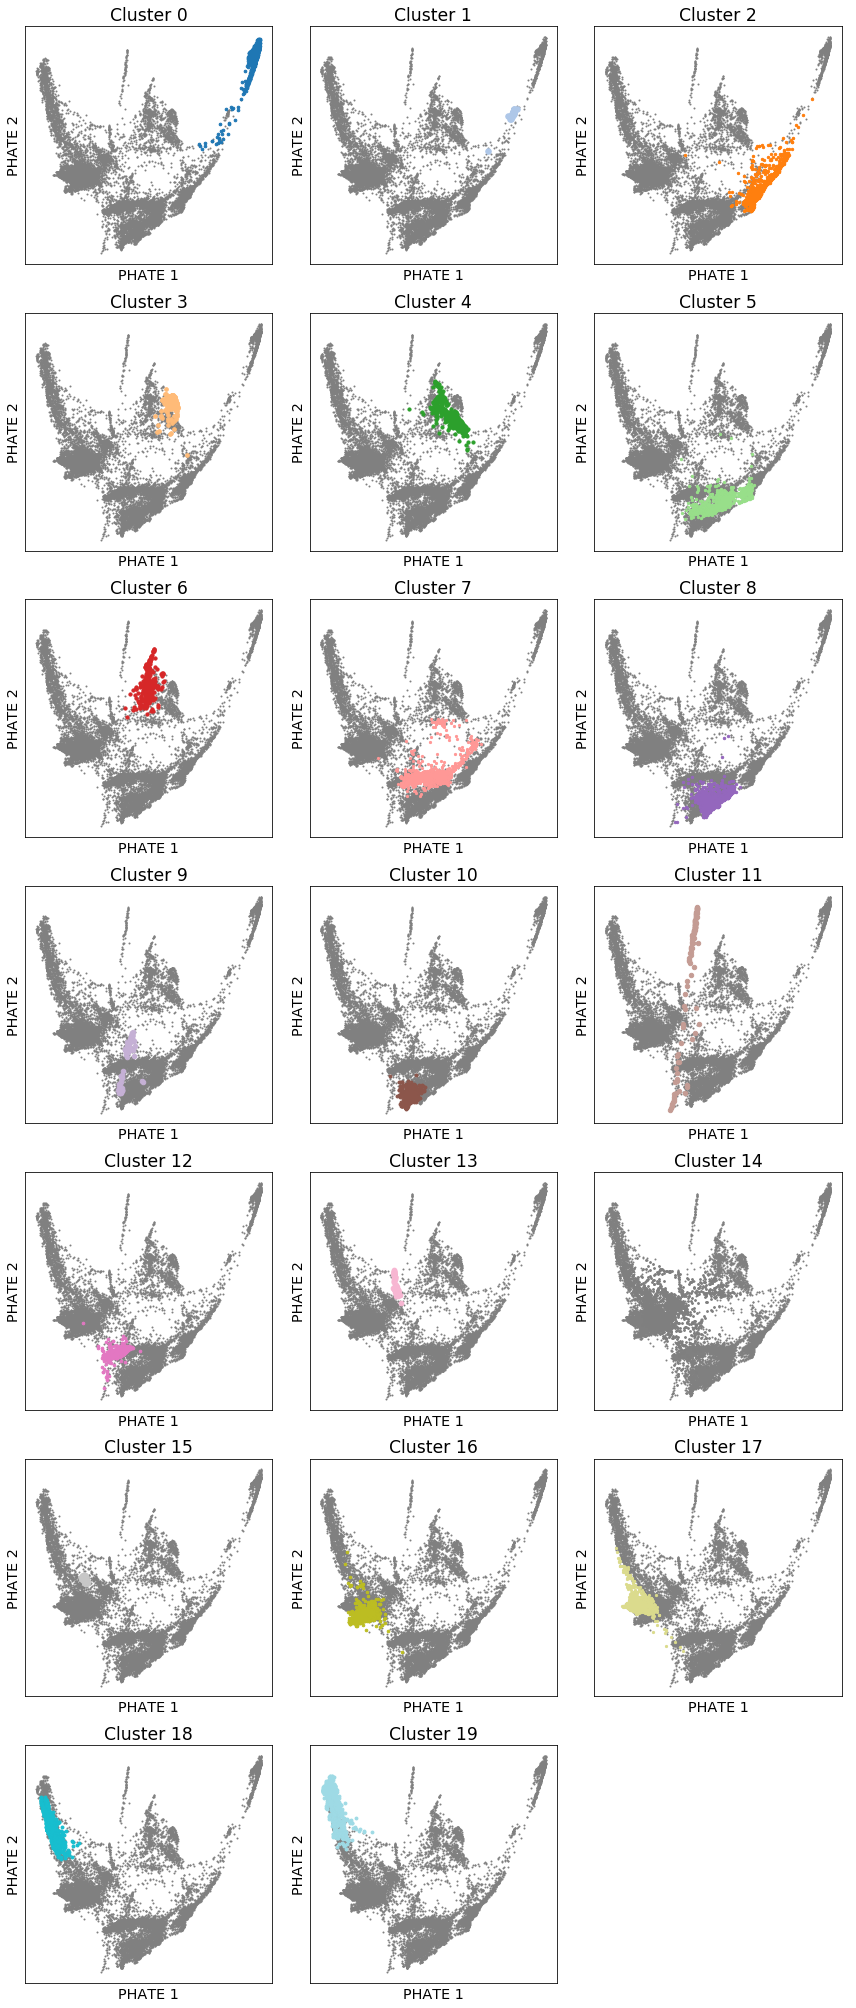

In [53]:
n_rows = 7
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*4))
axes = axes.flatten()
clusters = clusterings['Spectral']
for i, ax in enumerate(axes):
    try:
        curr_cluster = np.unique(clusters)[i]
    except IndexError:
        ax.axis('off')
        continue
    # Returns array([False, True,...,False]) indicating if each cell is in the
    # current cluster
    curr_mask = clusters == curr_cluster  
    scprep.plot.scatter2d(data_phate.loc[~curr_mask] , color='grey', zorder=0, s=1, ax=ax)
    scprep.plot.scatter2d(data_phate.loc[curr_mask], color=cluster_cmap[curr_cluster], title='Cluster {}'.format(curr_cluster),
                          ticks=False, label_prefix='PHATE ', ax=ax)


fig.tight_layout()

### How similar are the clustering algorithms?

We can use a metric, called the adjusted rand score, to quantify how similar any given clustering results are to each other. This is a similarity metric, so two identical clusterings will produce a score of `1.0`. If every point is randomly assigned to different clusters, then the adjusted rand score will be close to `0.0`. You can learn more about this metric in the `sklearn` user guide: https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score.

#### Grouping all of the cluster vectors into a single array

Reading the following code, can you guess what shape `all_clusterings` will be at the end of the code block? 

In [61]:
all_clusterings = []
all_algorithms = list(clusterings.keys())
for algo in all_algorithms:
    all_clusterings.append(clusterings[algo])    
all_clusterings = np.vstack(all_clusterings)

Here, we're using `pdist` with a custom distance metric. Note, `sklearn.metrics.adjusted_rand_score` is actually a similarity metric, not a distance metric. So this code is not good practice and qualifies as a hack. That being said, it works.

In [75]:
dists = scipy.spatial.distance.pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score)
# squareform assumes diagonals will be 0, but they're actually 1 because this is a similarity metric
# so we need to add 1's on the diagonal with np.eye()
dists = scipy.spatial.distance.squareform(dists) + np.eye(4)

#### Plot a clustermap of distances

With your partner, interpret this heatmap. Which cluster results are the most similar or different?

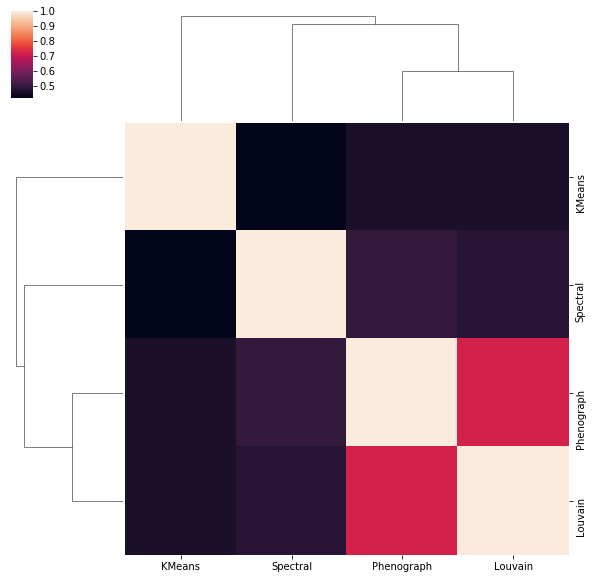

In [71]:
sns.clustermap(dists, xticklabels=all_algorithms, yticklabels=all_algorithms)



## Characterizing clusters

Now, we want to characterize gene expression in each cluster to identify the cell type of that cluster. Cell type is easy to grasp intuitively, but hard to formalize. Generally, we want a cell that expresses a set of genes differently than the rest of the cells in the dataset. As part of writing the PHATE paper, we characterized all the cell types in this time course, and made the following fate map.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/EB_lineage_map.png" style="height: 40rem;"/>

>Lineage tree of the EB system determined from the PHATE analysis showing embryonic stem cells (ESC), the primitive streak (PS), mesoderm  (ME), endoderm (EN), neuroectoderm (NE), neural crest (NC), neural progenitors (NP), lateral plate ME (LP ME), hemangioblast (H), cardiac (C), epicardial precursors (EP), smooth muscle precursors (SMP), cardiac precursors (CP), and neuronal subtypes (NS).

In groups, you need to examine the expression of these sets of genes and figure out which cell type matches your cluster.

#### Jitterplot

The following plot is called a [jitterplot](https://scprep.readthedocs.io/en/stable/examples/jitter.html). This plot is similar to a [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) or a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), but is computationally cheaper. The goal of this plot is to examine the distribution of values associated with each cell in a set of clusters.

Each point is a cell and the x-axis represents the cluster assignment of that cell. There's a little bit of noise added to the x-position of the cell (that's the jitter). The y-axis represents expression of a given gene.

You can change which gene is plotted by changing the `curr_gene` variable. All of the genes in the above plot will work.

FYI: when a gene is listed as `ZIC2/5`, this actually represents two genes: `ZIC2` and `ZIC5`.

Text(0.5, 1.0, 'POU5F1')

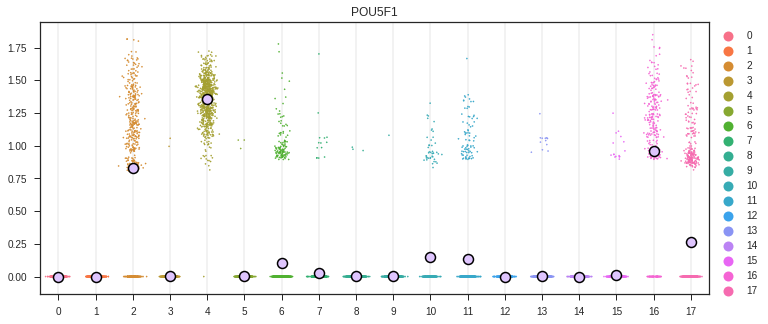

In [0]:
fig, ax = plt.subplots(1, figsize=(12, 5))

curr_gene = 'POU5F1'
curr_expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene)
curr_expression = curr_expression.iloc[:,0]
scprep.plot.jitter(clusters, curr_expression, c=clusters, cmap=cluster_cmap, ax=ax,
                  legend_anchor=(1,1))
ax.set_title(curr_gene)

Text(0.5, 1.0, 'NANOG')

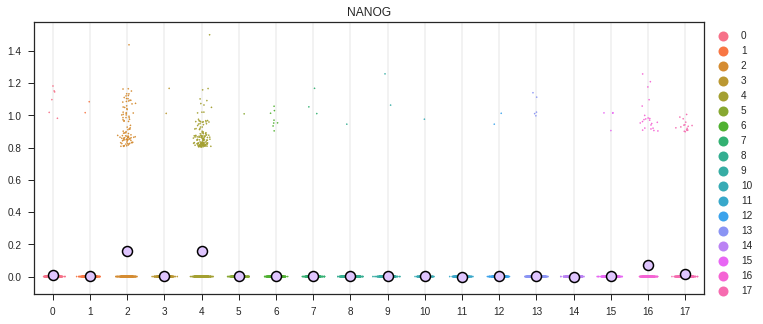

In [0]:
fig, ax = plt.subplots(1, figsize=(12, 5))

curr_gene = 'NANOG'
curr_expression = scprep.select.select_cols(EBT_counts, starts_with=curr_gene)
curr_expression = curr_expression.iloc[:,0]
scprep.plot.jitter(clusters, curr_expression, c=clusters, cmap=cluster_cmap, ax=ax,
                  legend_anchor=(1,1))
ax.set_title(curr_gene)

#### Examining expression on PHATE

The other tool you should use for examining clusters is the PHATE plots we used above. You can change the `genes_for_plotting` list, as long as you keep it restricted to three genes.

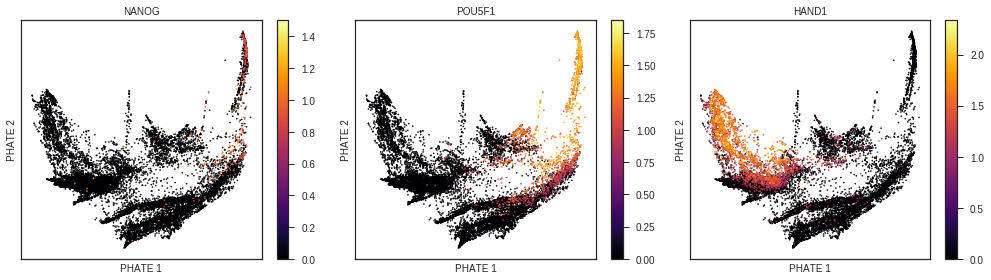

In [0]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
axes = axes.flatten()


genes_for_plotting = ['NANOG', 'POU5F1', 'HAND1']

for i, ax in enumerate(axes):
    curr_gene = genes_for_plotting[i]
    

    expression = scprep.select.select_cols(data, starts_with=curr_gene).to_dense()
    if expression.shape[1] > 1:
        expression = expression[expression.columns[0]]
        expression = pd.DataFrame(expression)
    
    sort_index = expression.sort_values(by=expression.columns[0]).index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE ', ax=ax)
    
fig.tight_layout()

## Discussion

Now, in your groups, you will be assigned to a cell type from the above lineage map. Please do the following tasks and be prepared to share your conclusions with the rest of the class.
1. Identify which cluster corresponds to your cell type of interest. 
2. Create a PHATE plot that highlights your cells of interest in some way (i.e. shows them in another color). Does this plot make sense with the position of your cell type in the developmental lineage? What information can you learn about your cell type from the PHATE plot?
3. Open coding exercise: Create another plot that shows something interesting about your cell type. This plot should answer a biological question, for example:

      a. Is the expression of marker genes heterogeneous within your cluster?
      
      b. Are your cells present at multiple time points?
      
      c. What other genes are uniquely expressed in your cell type?